In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [4]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [5]:

all_data =  read_parquet('../dec26-int16/*')
all_data


,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leasize,test_uniqueleaves,test_roc_auc,train_roc_auc,dataset,n_estimators,dtype,min_samples_leaf,target_max,experiment,folds,repetitions,run
0,1.0,NaN,0,70,40,2.0,2,0.786675,0.860355,1049,10,int16,128,32767,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128
1,2.0,NaN,0,70,40,2.0,4,0.819065,0.879584,1049,10,int16,128,32767,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128
2,4.0,NaN,0,70,40,2.0,8,0.823839,0.883325,1049,10,int16,128,32767,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128
3,8.0,NaN,0,70,40,2.0,16,0.821398,0.881440,1049,10,int16,128,32767,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128
4,16.0,NaN,0,70,40,2.0,32,0.822157,0.882458,1049,10,int16,128,32767,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58235,NaN,4.0,4,32262,16136,26.0,2631,0.998181,0.999978,6,10,int16,2,32767,min_samples_leaf-10-2,5,1,F37323_min_samples_leaf-10-2
58236,NaN,5.0,4,32262,16136,26.0,2771,0.998188,0.999979,6,10,int16,2,32767,min_samples_leaf-10-2,5,1,F37323_min_samples_leaf-10-2
58237,NaN,6.0,4,32262,16136,26.0,2786,0.998184,0.999979,6,10,int16,2,32767,min_samples_leaf-10-2,5,1,F37323_min_samples_leaf-10-2
58238,NaN,7.0,4,32262,16136,26.0,2786,0.998186,0.999979,6,10,int16,2,32767,min_samples_leaf-10-2,5,1,F37323_min_samples_leaf-10-2


In [6]:
all_data.leaves_per_class.value_counts(dropna=False)


leaves_per_class
NaN     20800
1.0      6240
2.0      6240
4.0      6240
8.0      6240
16.0     6240
32.0     6240
Name: count, dtype: int64

In [7]:
all_data.leaf_bits.value_counts(dropna=False)


leaf_bits
NaN    14560
4.0    14560
8.0    14560
0.0     2080
1.0     2080
2.0     2080
3.0     2080
5.0     2080
6.0     2080
7.0     2080
Name: count, dtype: int64

In [8]:

# Split into reference/baseline and not
is_ref = all_data.leaf_bits.isna() & all_data.leaves_per_class.isna()
ref = all_data[is_ref]
n_experiments = ref.min_samples_leaf.nunique() * ref.split.nunique() * ref.dataset.nunique()
assert len(ref) == n_experiments
hyper = all_data[~is_ref]

# Combine into one dataset
data = pandas.concat([ref, hyper], ignore_index=True)

# Enrich
data = enrich_results(data, leaf_node_bytes_default=4)
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data['trees'] = data['n_estimators']

# FIXME: why is this dataset ignored
data = data[~data.dataset.isin(['1510'])]
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,train_roc_auc,dataset,...,experiment,folds,repetitions,run,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,trees
id,,,,,,,,,,,,,,,,,,,,,
c210f9a2-9bac-4d37-a271-5989b9ca3c9e,NaN,NaN,0,70,40,2.0,32,82.215712,0.882458,1049,...,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128,256.0,240,496.0,51.612903,80.000000,10
20ffb0d6-7477-4890-9e71-f5d8d1bafe79,NaN,NaN,1,70,40,2.0,31,90.814887,0.901866,1049,...,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128,248.0,240,488.0,50.819672,77.500000,10
ac500491-21c9-4a4a-b8e9-d1c64cfa5be3,NaN,NaN,2,72,41,2.0,34,79.150391,0.869003,1049,...,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128,272.0,248,520.0,52.307692,82.926829,10
64a9d511-07b9-4c1b-ade4-162cb8a87bb2,NaN,NaN,3,80,45,2.0,41,86.428571,0.869748,1049,...,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128,328.0,280,608.0,53.947368,91.111111,10
acb3e426-bd0a-4b88-9927-d45778ee3900,NaN,NaN,4,72,41,2.0,33,88.080357,0.867222,1049,...,min_samples_leaf-10-128,5,1,291A62_min_samples_leaf-10-128,264.0,248,512.0,51.562500,80.487805,10


In [9]:
ref.columns

Index(['leaves_per_class', 'leaf_bits', 'split', 'test_nodes', 'test_leaves',
       'test_leasize', 'test_uniqueleaves', 'test_roc_auc', 'train_roc_auc',
       'dataset', 'n_estimators', 'dtype', 'min_samples_leaf', 'target_max',
       'experiment', 'folds', 'repetitions', 'run'],
      dtype='object')

In [10]:

def compute_perf_change(df, groupby='dataset', metric='test_roc_auc', ref=None):
    df = df.copy()

    ref_df = ref.reset_index().groupby('dataset').median(numeric_only=True)
    
    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby('dataset', as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')[metric]
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    return df

from src.experiments.analyze import name_strategies

unoptimized = name_strategies(data)
unoptimized = unoptimized[unoptimized.strategy.isin(['majority', 'original', 'joint'])]
unoptimized.loc[(unoptimized.experiment == 'sklearn_defaults') & (unoptimized.strategy != 'original')] = None
unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaf_bits != 4), 'strategy'] = None
#unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaves_per_class != 8), 'strategy'] = None
unoptimized = unoptimized.dropna(subset=['strategy'])
#print(unoptimized[unoptimized.experiment == 'sklearn_defaults']['strategy'].value_counts())
print(unoptimized.experiment.value_counts())
print(unoptimized.strategy.value_counts())
ref = enrich_results(ref, leaf_node_bytes_default=4)
unoptimized = compute_perf_change(unoptimized, groupby=['dataset'], ref=ref)
unoptimized.head(1)

#unoptimized.experiment.value_counts()

experiment
min_samples_leaf-10-128    2040
min_samples_leaf-10-32     2040
min_samples_leaf-10-16     2040
min_samples_leaf-10-8      2040
min_samples_leaf-10-4      2040
min_samples_leaf-10-1      2040
min_samples_leaf-10-64     2040
min_samples_leaf-10-2      2040
Name: count, dtype: int64
strategy
joint       12240
original     2040
majority     2040
Name: count, dtype: int64


,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,train_roc_auc,dataset,...,run,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,trees,strategy,perf_change,size_change
id,,,,,,,,,,,,,,,,,,,,,
c210f9a2-9bac-4d37-a271-5989b9ca3c9e,NaN,NaN,0,70,40,2.0,32,82.215712,0.882458,1049,...,291A62_min_samples_leaf-10-128,256.0,240,496.0,51.612903,80.0,10,original,-8.850136,0.172943


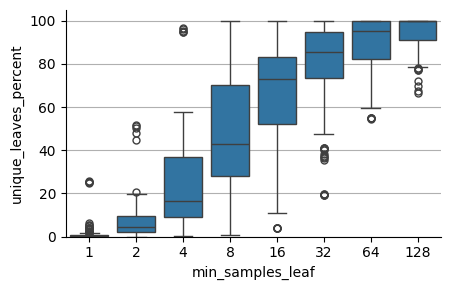

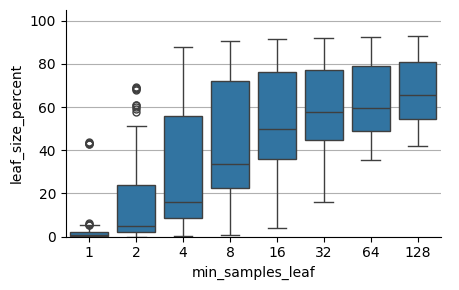

In [11]:
depth_limit = 'min_samples_leaf'
#depth_limit = 'max_depth'


def add_grid(g, **kwargs):
    for i, ax in enumerate(g.axes.flatten()):
        ax.grid(**kwargs)


sel = unoptimized[(unoptimized.strategy == 'original')]
unoptimized[(unoptimized.strategy == 'original') & (unoptimized.trees == 10)]

#fig, axs = plt.subplots(ncols=2)
height = 3.0
aspect = 1.5
g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='unique_leaves_percent', 
                height=height, aspect=aspect)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-uniqueness.png')

g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='leaf_size_percent', 
                height=height, aspect=aspect,)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-proportion.png')



In [12]:
reduced = unoptimized.copy()
reduced = reduced[~reduced.experiment.isin(['sklearn_defaults'])]
reduced.shape

(16320, 27)

In [13]:
reduced.columns

Index(['leaves_per_class', 'leaf_bits', 'split', 'test_nodes', 'test_leaves',
       'test_leafsize', 'test_uniqueleaves', 'test_roc_auc', 'train_roc_auc',
       'dataset', 'n_estimators', 'dtype', 'min_samples_leaf', 'target_max',
       'experiment', 'folds', 'repetitions', 'run', 'leaf_size',
       'decision_size', 'total_size', 'leaf_size_percent',
       'unique_leaves_percent', 'trees', 'strategy', 'perf_change',
       'size_change'],
      dtype='object')

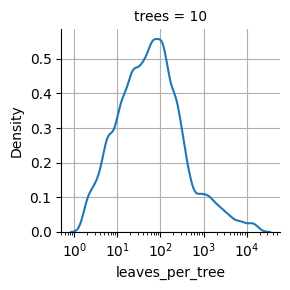

In [14]:
sel = reduced.reset_index()
sel[sel.trees == 10]
sel['leaves_per_tree'] = sel.test_leaves / sel.trees
g = seaborn.displot(data=sel, kind='kde', x='leaves_per_tree',
                col='trees', #col_wrap=4,
                height=3.0,
                log_scale=(True, False), common_norm=False,
                #stat='percent'
               )

for ax in g.axes.flatten():
    ax.grid()  

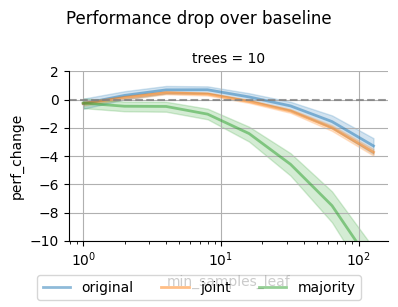

In [15]:

col_order = sorted(reduced.trees.unique(), reverse=True)
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x=depth_limit,
                    y='perf_change',
                    hue='strategy',
                    col='trees',
                    col_order=col_order,
                    aspect=1, height=3,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
#g.set(xlim=(1, 100))
g.set(ylim=(-10, 2))
g.refline(y=0.0, alpha=0.8, ls='--')
#g.refline(y=-2.0, alpha=0.5, color='black')
#g.refline(y=-4.0, alpha=0.5, color='orange')
for i, ax in enumerate(g.axes.flatten()):
    ax.grid()
    if i >= 1:
        x_axis = ax.axes.get_xaxis()
        x_axis.get_label().set_visible(False)


g.figure.suptitle('Performance drop over baseline')
g.figure.tight_layout()
g.figure.legends = []
g.figure.legend(loc="lower center", ncol=3)
g.figure.savefig('hyperparam-perfdrop-trees-strategies.png')


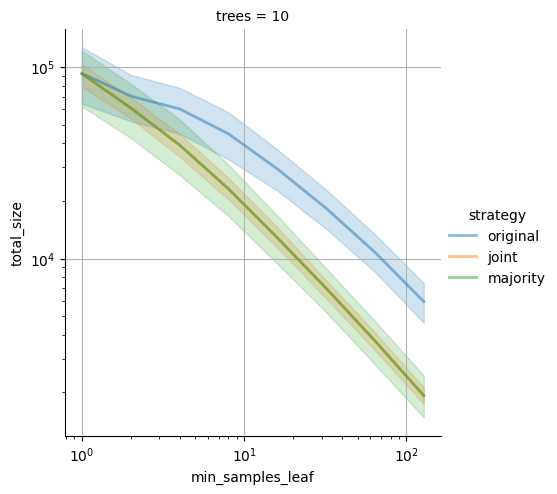

In [16]:
sel = reduced.reset_index()
#sel = sel[sel.leaf_bits == 8]
g = seaborn.relplot(data=sel,
                    kind='line',
                    x='min_samples_leaf',
                    y='total_size',
                    hue='strategy',
                    col='trees',
                    aspect=1.0, height=5,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log", yscale='log')
for ax in g.axes.flatten():
    ax.grid()


In [17]:

import numpy

def aggregated_performance(df, agg='median'):
    folds = 5 
    repetitions = 1
    results_per_group = repetitions * folds

    groups = df.groupby(['dataset', 'strategy', 'min_samples_leaf', 'trees', 'leaves_per_class'], as_index=True, dropna=False)
    metrics = ['perf_change', 'total_size']

    # check that we got all the results / have specified the groups correctly
    for idx, g in groups:
        mismatch = len(g) != results_per_group
        if mismatch:
            print(idx, len(g))
            print(g['id'].nunique())
            print(g['run'].unique())
            print(g.head(30))
            raise ValueError('wrong numer of values per group')
            
    out = groups.agg(agg, numeric_only=True)[metrics]
    return out


if False:
    sel = reduced.reset_index()
    sel = aggregated_performance(sel)
    sel = sel.sort_values('dataset', ascending=False)
    g = seaborn.relplot(data=sel,
                        kind='scatter',
                        x='total_size',
                        y='perf_change',
                        hue='strategy',
                        col='dataset',
                        col_wrap=4,
                        aspect=3, height=4,
                        legend=True,
                        #lw=2.0,
                        s=20.0,
                        alpha=0.7,
                       )
    
    g.figure.tight_layout()
    g.figure.legends = []
    g.figure.legend(loc="upper center", ncol=3)
    
    g.set(xscale="log")
    g.set(ylim=(-20, 10))
    g.set(xlim=(100, 100e3))
    g.refline(y=0.0, lw=2.0)
    for ax in g.axes.flatten():
        ax.grid()  

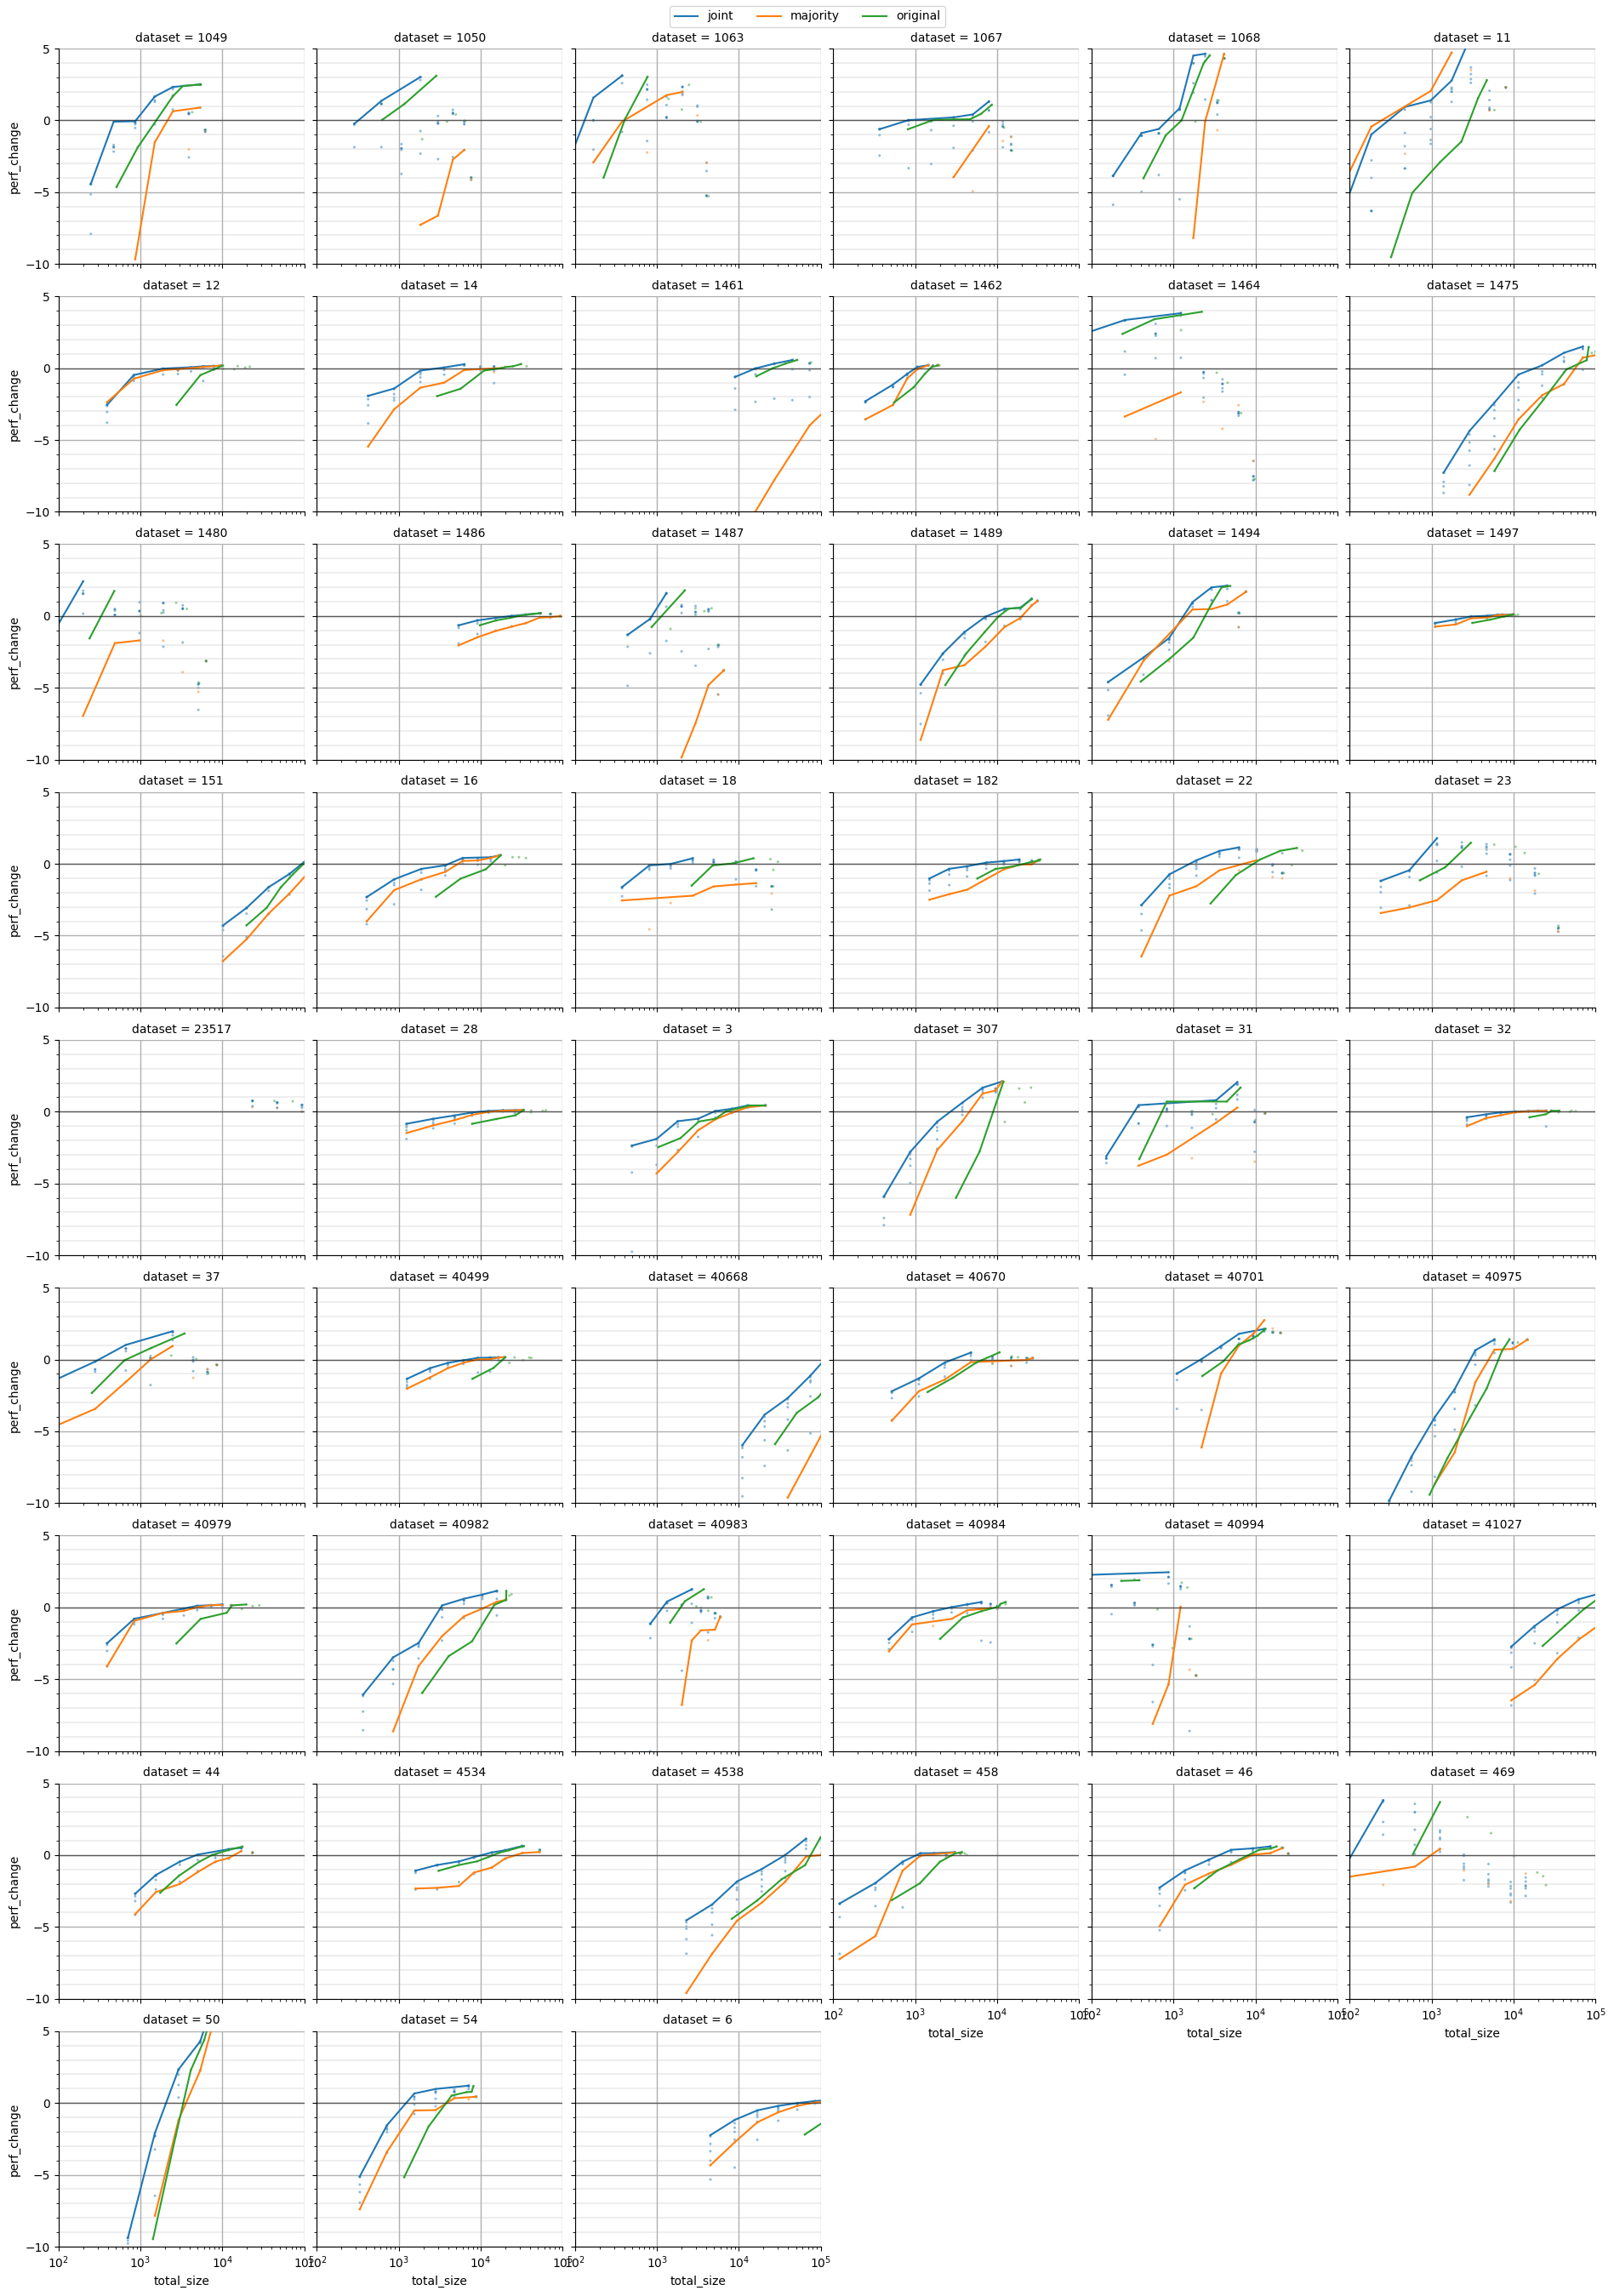

In [32]:

from src.utils.pareto import find_pareto_front, plot_pareto_front


sel = reduced.reset_index()
sel = aggregated_performance(sel)
sel = sel.sort_values('dataset', ascending=False)
#sel = sel.sort_values('dataset', ascending=False)

def find_pareto(df, cost_metric='total_size', performance_metric='perf_change',  min_performance=-10.0):

    pareto_params = dict(
        cost_metric=cost_metric,
        performance_metric=performance_metric,
        min_performance=min_performance,
    )
    
    pf = find_pareto_front(df, **pareto_params)
    pf['point'] = numpy.arange(len(pf))
    pf = pf.set_index('point')
    #print(len(pf))
    return pf

# ensure consistent order
strategy_order = ['joint', 'majority', 'original']

# Plot pareto front as lines
pareto = sel.groupby(['dataset', 'strategy'], as_index=True).apply(find_pareto)
g = seaborn.relplot(data=pareto.reset_index(),
                kind='line',
                col='dataset',
                col_wrap=6,
                y='perf_change',
                x='total_size',
                hue='strategy',
                hue_order=strategy_order,
                height=3.0,
                aspect=1.0,
                legend=True,
               )

# Add scatter plots of original data
for ax, (_, facet_data) in zip(g.axes.flat, g.facet_data()):
    facet_dataset = facet_data.dataset.unique()
    #print(facet_dataset)
    assert len(facet_dataset) == 1
    facet_dataset = facet_dataset[0]
    scatter_data = sel.loc[facet_dataset]
    seaborn.scatterplot(ax=ax,
        data=scatter_data.reset_index(),
        y='perf_change',
        x='total_size',
        hue='strategy',
        hue_order=strategy_order,
        alpha=0.5,
        legend=False,
        s=5.0,
        zorder=1,
    )
    
# Configure scale
g.set(xscale="log")
g.set(ylim=(-10, 5))
g.set(xlim=(100, 100e3))
g.refline(y=0.0, ls='-', color='black', alpha=0.5, lw=1.0)

# Configure legend
g.figure.legends = []
g.figure.legend(loc="upper center", ncol=3)
g.figure.tight_layout()

# Configure grid
from matplotlib.ticker import LinearLocator, FixedLocator, MultipleLocator
for ax in g.axes.flat:
    ax.grid(True, which='major', axis='x', linestyle='-', linewidth=1.0)
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=1.0)
    ax.grid(True, which='minor', axis='y', linestyle='-', linewidth=0.3)
    ax.yaxis.set_major_locator(MultipleLocator(5.0))
    ax.yaxis.set_minor_locator(MultipleLocator(1.0))

# Reduce space beween subplots, and make room for legend up top
g.figure.subplots_adjust(wspace=0.05, hspace=0.15, top=0.98)


fig = g.figure
fig.savefig('perf-pareto-datasets.png')


In [19]:

def find_differences(pareto, groups='strategy', ref='joint'):

    p = pareto.set_index(groups)
    ref_values = p.loc[ref]

    other = pandas.concat([p.loc['majority'], p.loc['original']], ignore_index=True)

    cost_metric = 'total_size'
    performance_metric = 'perf_change'

    records = []
    for _, row in ref_values.iterrows():
        ref_performance = row[performance_metric]
        ref_cost = row[cost_metric]
        
        sub = other[other[performance_metric] >= ref_performance]
        alt_cost = sub[cost_metric].min()

        rel = alt_cost / ref_cost 
        
        records.append({'point': row.point, 'gain': rel})

    out = pandas.DataFrame.from_records(records).set_index('point')
    return out

    #print(ref_values)
    #print(other)

gains = pareto.reset_index().groupby('dataset', as_index=True).apply(find_differences)
gains

AttributeError: 'Series' object has no attribute 'iterrows'

In [ ]:
g = seaborn.displot(data=gains.reset_index(), x='gain', binrange=(0,6), binwidth=0.10)
g.refline(x=1.0)

In [ ]:
order = gains.groupby('dataset').median()['gain'].sort_values(ascending=False)
#print(order)
g = seaborn.catplot(data=gains.reset_index(),
                    kind='box',
                    x='gain',
                    aspect=1,
                    height=8.0,
                    y='dataset',
                    order=order.index)
for ax in g.axes.flatten():
    ax.grid(axis='x')
g.set(xlim=(0, 10))
g.refline(x=1.0)

In [ ]:
dataset_classes = data.groupby('dataset')['test_leafsize'].median().rename('n_classes')
gains = pandas.merge(gains.reset_index(), dataset_classes, left_on='dataset', right_index=True)
gains

In [ ]:

order = gains.groupby('dataset').median()['gain'].sort_values(ascending=False)
#print(order)
g = seaborn.catplot(data=gains.reset_index(),
                    kind='box',
                    y='gain',
                    x='n_classes',
                    #hue='dataset',
                    aspect=2,
                    height=5.0,
                )
for ax in g.axes.flatten():
    ax.grid(axis='x')
g.set(ylim=(0, 10))
g.refline(y=1.0)


In [ ]:
g = seaborn.displot(data=unoptimized, kind='hist', x='test_uniqueleaves', col='strategy', height=5, log_scale=(True, False), common_norm=False, stat='percent')
#g.set(xscale='log')
g.refline(x=2**8)
g.refline(x=2**15)

In [ ]:
unoptimized.columns

In [ ]:
sel = unoptimized.copy()
sel['leaf_percentage'] = 100 * (sel.test_leaves / sel.test_nodes)
sel['leaf_to_decision_nodes'] = sel.test_leaves / (sel.test_nodes - sel.test_leaves)
seaborn.displot(sel, kind='hist', x='leaf_to_decision_nodes', col='min_samples_leaf', col_wrap=4, height=3.0)